In [ ]:
from torch import nn
from tqdm import tqdm

from torchvision.datasets import mnist, cifar
from torchvision import transforms

from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
batch_size = 8
batches_per_epoch = 128
test_size_mnist = 128
train_size_mnist = 5120
test_size_cifar = 1024
train_size_cifar = 48976

In [ ]:
mnist_dataset = mnist.MNIST(
    root = 'data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

mnist_dataloader = {
    "train": DataLoader(Subset(mnist_dataset, range(test_size_mnist, test_size_mnist + train_size_mnist)), shuffle=True, batch_size=batch_size),
    "test": DataLoader(Subset(mnist_dataset, range(0, test_size_mnist)), shuffle=True, batch_size=batch_size)
}

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

cifar_dataset = cifar.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=transform
)

cifar_dataloader = {
    "train": DataLoader(Subset(cifar_dataset, range(test_size_cifar, test_size_cifar + train_size_cifar)), shuffle=True, batch_size=batch_size),
    "test": DataLoader(Subset(cifar_dataset, range(0, test_size_cifar)), shuffle=True, batch_size=batch_size)
}

100%|██████████| 9912422/9912422 [00:00<00:00, 91644483.34it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 108253524.42it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29283778.48it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21550371.91it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 170498071/170498071 [00:03<00:00, 55249452.91it/s]


Extracting data/cifar-10-python.tar.gz to data


In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, image):
        output = self.conv(image)
        output = self.fc(output.view(image.shape[0], -1))
        return output

In [ ]:
class MiniVGG(nn.Module):
    def __init__(self):
        super(MiniVGG, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, 10)
        )

    def forward(self, image):
        output = self.features(image)
        output = output.view(image.shape[0], -1)
        output = self.classifier(output)
        return output

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch)
        )
        self.relu = nn.ReLU()
        if in_ch != out_ch:
            self.downsaple = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1)
        else:
            self.downsaple = None

    def forward(self, image):
        residual = image
        output = self.conv1(image)
        output = self.conv2(output)
        if self.downsaple is not None:
            residual = self.downsaple(residual)
        output += residual
        output = self.relu(output)
        return output

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.layer1 = ResidualBlock(16, 16, 1)
        self.layer2 = ResidualBlock(16, 32, 2)
        self.layer3 = ResidualBlock(32, 64, 2)
        self.avgpool = nn.AvgPool2d(7, stride=2)
        self.fc = nn.Sequential(
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10)
        )
    def forward(self, image):
        output = self.conv1(image)
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.avgpool(output)
        output = output.view(image.shape[0], -1)
        output = self.fc(output)
        return output

In [ ]:
def train_model_and_plot(model, optimizer, dataloader, epochs=50, lr=0.001):
    model.to(device)
    train_acc, test_acc = [], []
    if optimizer == "NAG":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, nesterov=True, momentum=0.9)
    else:
        optimizer = optimizer(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in tqdm(range(epochs)):
        if epoch == 200:
            optimizer.param_groups[0]['lr'] /= 10
        running_accuracy = 0
        i = 0
        for x, y in dataloader["train"]:
            x, y = x.to(device), y.to(device)
            prediction = model(x)
            loss = loss_fn(prediction, y)
            running_accuracy += (prediction.softmax(dim=1).argmax(dim=1) == y).float().mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            i += 1
            if i == batches_per_epoch:
                break
        running_accuracy /= batches_per_epoch
        train_acc.append(running_accuracy.cpu())

        with torch.no_grad():
            running_accuracy = 0
            for x, y in dataloader['test']:
                x, y = x.to(device), y.to(device)
                prediction = model(x)
                running_accuracy += (prediction.softmax(dim=1).argmax(dim=1) == y).float().mean()
            running_accuracy /= len(dataloader['test'])
            test_acc.append(running_accuracy.cpu())
    plt.plot(range(1, epochs + 1), train_acc, label="train")
    plt.plot(range(1, epochs + 1), test_acc, label="test")
    plt.legend()
    plt.show()
    print(train_acc[-1])
    print(test_acc[-1])

100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


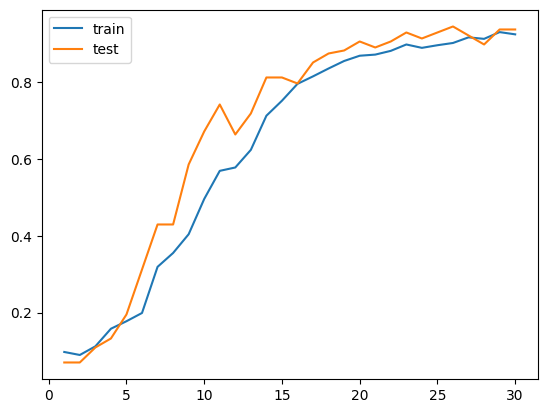

tensor(0.9248)
tensor(0.9375)


In [ ]:
train_model_and_plot(LeNet(), torch.optim.SGD, mnist_dataloader, epochs=30, lr=0.0055)

100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


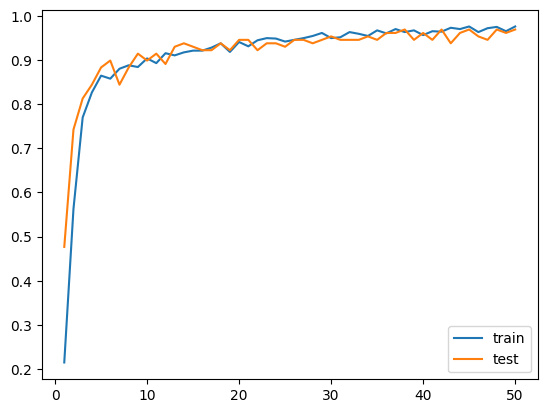

tensor(0.9756)
tensor(0.9688)


In [ ]:
train_model_and_plot(LeNet(), torch.optim.Adadelta, mnist_dataloader, epochs=50, lr=0.1)

100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


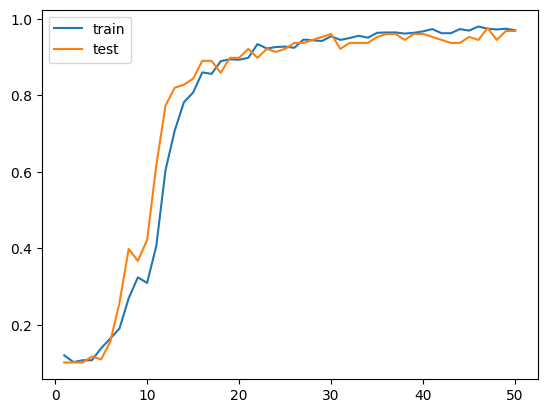

tensor(0.9707)
tensor(0.9688)


In [ ]:
train_model_and_plot(LeNet(), "NAG", mnist_dataloader, epochs=50, lr=0.001)

100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


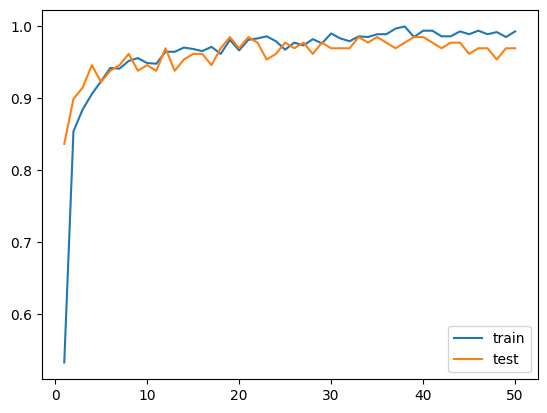

tensor(0.9922)
tensor(0.9688)


In [ ]:
train_model_and_plot(LeNet(), torch.optim.Adam, mnist_dataloader, epochs=50, lr=0.001)

100%|██████████| 250/250 [05:44<00:00,  1.38s/it]


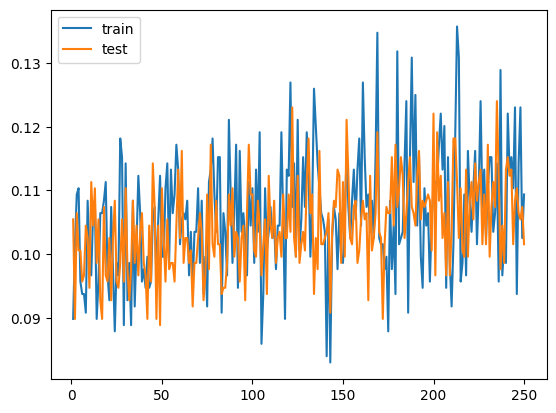

tensor(0.1094)
tensor(0.1016)


In [ ]:
train_model_and_plot(MiniVGG(), torch.optim.SGD, cifar_dataloader, epochs=250, lr=0.0001)

100%|██████████| 250/250 [05:45<00:00,  1.38s/it]


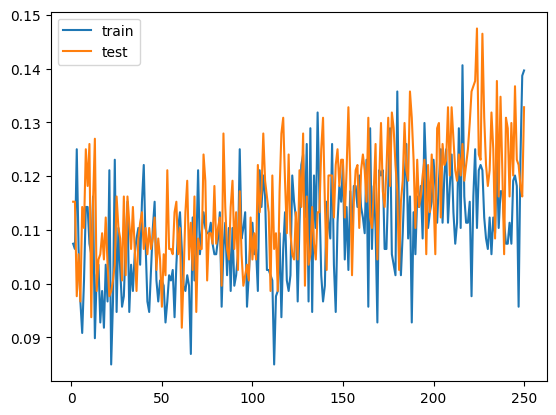

tensor(0.1396)
tensor(0.1328)


In [ ]:
train_model_and_plot(MiniVGG(), torch.optim.Adadelta, cifar_dataloader, epochs=250, lr=0.0001)

100%|██████████| 250/250 [05:41<00:00,  1.37s/it]


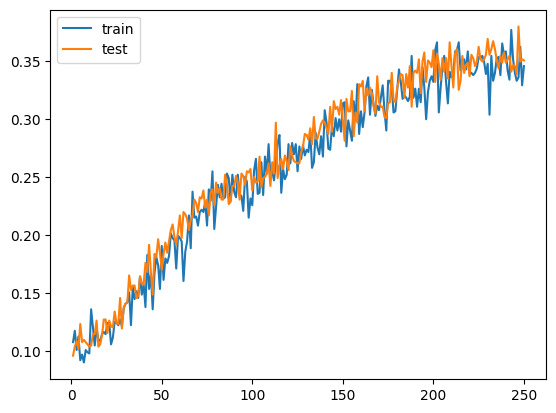

tensor(0.3457)
tensor(0.3506)


In [ ]:
train_model_and_plot(MiniVGG(), "NAG", cifar_dataloader, epochs=250, lr=0.0001)

100%|██████████| 250/250 [05:50<00:00,  1.40s/it]


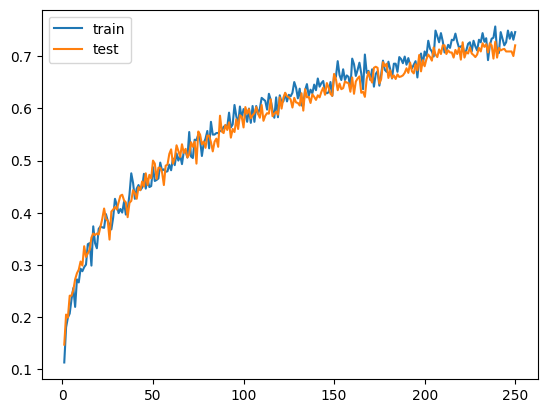

tensor(0.7461)
tensor(0.7207)


In [ ]:
train_model_and_plot(MiniVGG(), torch.optim.Adam, cifar_dataloader, epochs=250, lr=0.0001)

100%|██████████| 250/250 [07:06<00:00,  1.71s/it]


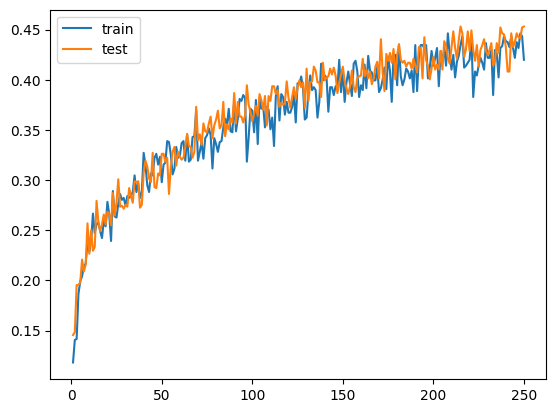

tensor(0.4199)
tensor(0.4531)


In [ ]:
train_model_and_plot(ResNet(), torch.optim.SGD, cifar_dataloader, epochs=250, lr=0.00015)

100%|██████████| 250/250 [07:22<00:00,  1.77s/it]


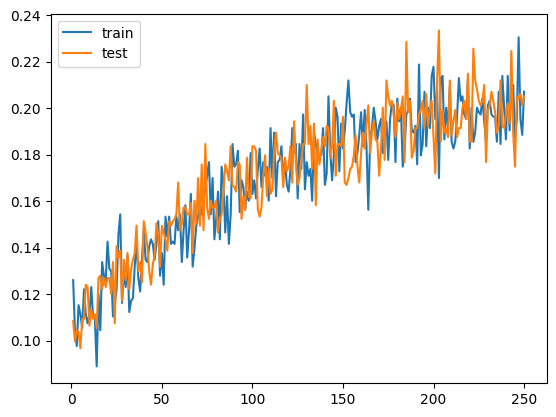

tensor(0.2070)
tensor(0.2051)


In [ ]:
train_model_and_plot(ResNet(), torch.optim.Adadelta, cifar_dataloader, epochs=250, lr=0.00015)

100%|██████████| 250/250 [07:06<00:00,  1.71s/it]


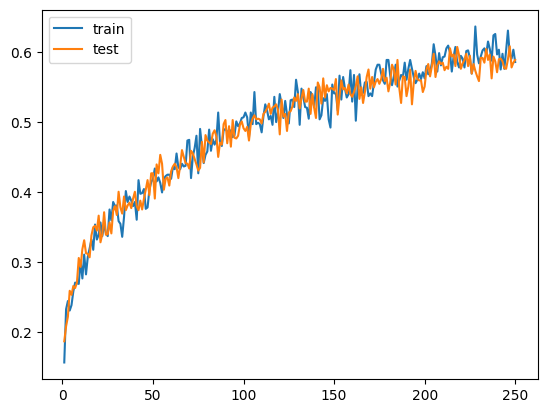

tensor(0.5859)
tensor(0.5889)


In [ ]:
train_model_and_plot(ResNet(), "NAG", cifar_dataloader, epochs=250, lr=0.00015)

100%|██████████| 250/250 [07:22<00:00,  1.77s/it]


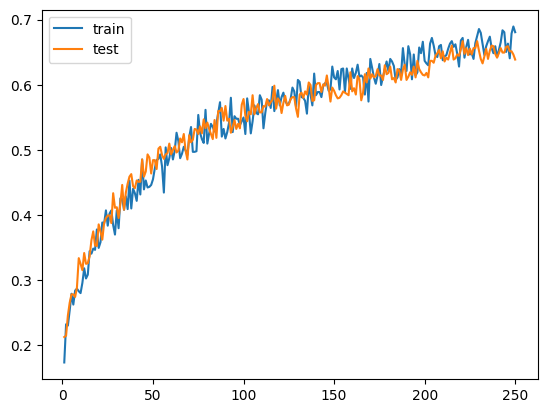

tensor(0.6807)
tensor(0.6387)


In [ ]:
train_model_and_plot(ResNet(), torch.optim.Adam, cifar_dataloader, epochs=250, lr=0.000155e-4)